# **Severidad**

## Librerias

In [34]:
library(dplyr)
library(ggplot2)
library(MASS)
library(car)
library(broom)
library(hnp)

## Data

In [35]:
data <- read.csv("../data/processed/tabla_severidad.csv")
data$X <- NULL

In [36]:
head(data)

,Modelo,Color,Carroceria,CLASE_FASECOLDA,TIPO_VEHICULO,SERVICIO,Sexo_Aseg,Edad,Gama,n_siniestros,exposicion_total,suma_pagos,n_observaciones,severidad_media
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<dbl>
1,1993_1999,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,F,19_41,Baja,2,6.602740,8014069,13,4007034.6
2,1993_1999,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,F,41_63,Baja,2,10.580822,2204046,22,1102023.2
3,1993_1999,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,M,19_41,Baja,4,11.569863,6450375,23,1612593.7
4,1993_1999,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,M,41_63,Baja,2,8.430137,4238816,16,2119408.0
5,1993_1999,Otros,Otros,CAMIONETA,Livianos,Particular,F,41_63,Baja,2,3.010959,1208679,6,604339.6
6,1993_1999,Otros,SEDAN,AUTOMOVIL,Livianos,Particular,F,19_41,Baja,2,16.800000,8213167,35,4106583.6


In [37]:
head(sort(unique(data$valor)))

NULL

In [38]:
establecer_categorias_referencia <- function(df, vars_categoricas, var_exposicion = "exposicion_total") {
  df_copy <- df
  
  for (var in vars_categoricas) {
    exposicion_por_categoria <- aggregate(df_copy[[var_exposicion]], 
                                        by = list(df_copy[[var]]), 
                                        FUN = sum, na.rm = TRUE)
    names(exposicion_por_categoria) <- c("categoria", "exposicion_total")
    
    categoria_referencia <- exposicion_por_categoria$categoria[which.max(exposicion_por_categoria$exposicion_total)]
    
    cat("Variable:", var, "- Categoría de referencia:", categoria_referencia, "\n")
    
    df_copy[[var]] <- factor(df_copy[[var]])
    df_copy[[var]] <- relevel(df_copy[[var]], ref = as.character(categoria_referencia))
  }
  
  return(df_copy)
}

vars_categoricas <- c("Modelo", "Color", "Carroceria", "CLASE_FASECOLDA", 
                     "TIPO_VEHICULO", "SERVICIO", "Sexo_Aseg", "Edad", "Gama")

data <- establecer_categorias_referencia(data, vars_categoricas)

str(data)

Variable: Modelo - Categoría de referencia: 2007_2013 
Variable: Color - Categoría de referencia: Otros 
Variable: Carroceria - Categoría de referencia: SEDAN 
Variable: CLASE_FASECOLDA - Categoría de referencia: AUTOMOVIL 
Variable: TIPO_VEHICULO - Categoría de referencia: Livianos 
Variable: SERVICIO - Categoría de referencia: Particular 
Variable: Sexo_Aseg - Categoría de referencia: M 
Variable: Edad - Categoría de referencia: 41_63 
Variable: Gama - Categoría de referencia: Media 
'data.frame':	229 obs. of  14 variables:
 $ Modelo          : Factor w/ 3 levels "2007_2013","1993_1999",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Color           : Factor w/ 4 levels "Otros","AMARILLO",..: 3 3 3 3 1 1 1 1 1 1 ...
 $ Carroceria      : Factor w/ 4 levels "SEDAN","CABINADO",..: 1 1 1 1 4 1 1 1 1 1 ...
 $ CLASE_FASECOLDA : Factor w/ 4 levels "AUTOMOVIL","AUTOMOVIL TAXI",..: 1 1 1 1 3 1 1 1 1 1 ...
 $ TIPO_VEHICULO   : Factor w/ 2 levels "Livianos","Pesados": 1 1 1 1 1 1 1 1 1 1 ...
 $ SERVICIO        

# **Gamma**

## Seleccion de variables

In [39]:
names(data)

[1] "Modelo"           "Color"            "Carroceria"       "CLASE_FASECOLDA" 
 [5] "TIPO_VEHICULO"    "SERVICIO"         "Sexo_Aseg"        "Edad"            
 [9] "Gama"             "n_siniestros"     "exposicion_total" "suma_pagos"      
[13] "n_observaciones"  "severidad_media"

In [40]:
modelo_sev_completo <- glm(
  suma_pagos ~ Modelo + Color + Carroceria + CLASE_FASECOLDA + 
               TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Edad,
  family = Gamma(link = "log"),
  weights = n_siniestros,
  data = data
)

modelo_sev_nulo <- glm(
  suma_pagos ~ 1,
  family = Gamma(link = "log"),
  weights = n_siniestros,
  data = data
)

modelo_severidad_gamma <- step(
  modelo_sev_completo,
  scope = list(lower = modelo_sev_nulo, upper = modelo_sev_completo),
  direction = "forward",
  trace = TRUE
)

summary(modelo_severidad_gamma)

Start:  AIC=32909.37
suma_pagos ~ Modelo + Color + Carroceria + CLASE_FASECOLDA + 
    TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Edad




Call:
glm(formula = suma_pagos ~ Modelo + Color + Carroceria + CLASE_FASECOLDA + 
    TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Edad, family = Gamma(link = "log"), 
    data = data, weights = n_siniestros)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.1381  -1.8271  -0.9617   0.1099   6.2252  

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   17.24957    0.14716 117.220  < 2e-16 ***
Modelo1993_1999               -1.20419    0.33125  -3.635 0.000350 ***
Modelo2000_2006               -0.63254    0.16563  -3.819 0.000177 ***
ColorAMARILLO                 -2.13837    0.64723  -3.304 0.001123 ** 
ColorBLANCO                   -0.57261    0.18599  -3.079 0.002359 ** 
ColorPLATA                    -0.63750    0.15676  -4.067 6.76e-05 ***
CarroceriaCABINADO            -0.98982    0.36065  -2.745 0.006590 ** 
CarroceriaHATCHBACK            0.29506    0.13850   2.130 0.034316 *  
CarroceriaOtros             

## Modelo simplificado

In [41]:
modelo_severidad_gamma <- glm(
  suma_pagos ~ Modelo + Color + Carroceria + SERVICIO,
  family = Gamma(link = "log"),
  weights = n_siniestros,
  data = data
)
summary(modelo_severidad_gamma)


Call:
glm(formula = suma_pagos ~ Modelo + Color + Carroceria + SERVICIO, 
    family = Gamma(link = "log"), data = data, weights = n_siniestros)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.938  -1.900  -1.030   0.013   6.427  

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 17.24239    0.11633 148.216  < 2e-16 ***
Modelo1993_1999             -1.28842    0.33185  -3.882 0.000137 ***
Modelo2000_2006             -0.76456    0.16328  -4.683 4.99e-06 ***
ColorAMARILLO               -2.42918    0.36047  -6.739 1.42e-10 ***
ColorBLANCO                 -0.53211    0.17941  -2.966 0.003356 ** 
ColorPLATA                  -0.65906    0.15465  -4.262 3.03e-05 ***
CarroceriaCABINADO          -1.04723    0.19787  -5.292 2.95e-07 ***
CarroceriaHATCHBACK          0.27328    0.13782   1.983 0.048641 *  
CarroceriaOtros             -1.10793    0.21378  -5.183 5.00e-07 ***
SERVICIOOficial              0.05596    0.271

pdf 
  2

Gamma model 
Total points: 229 
Points out of envelope: 191 ( 83.41 %) 


pdf 
  2

Gamma model 


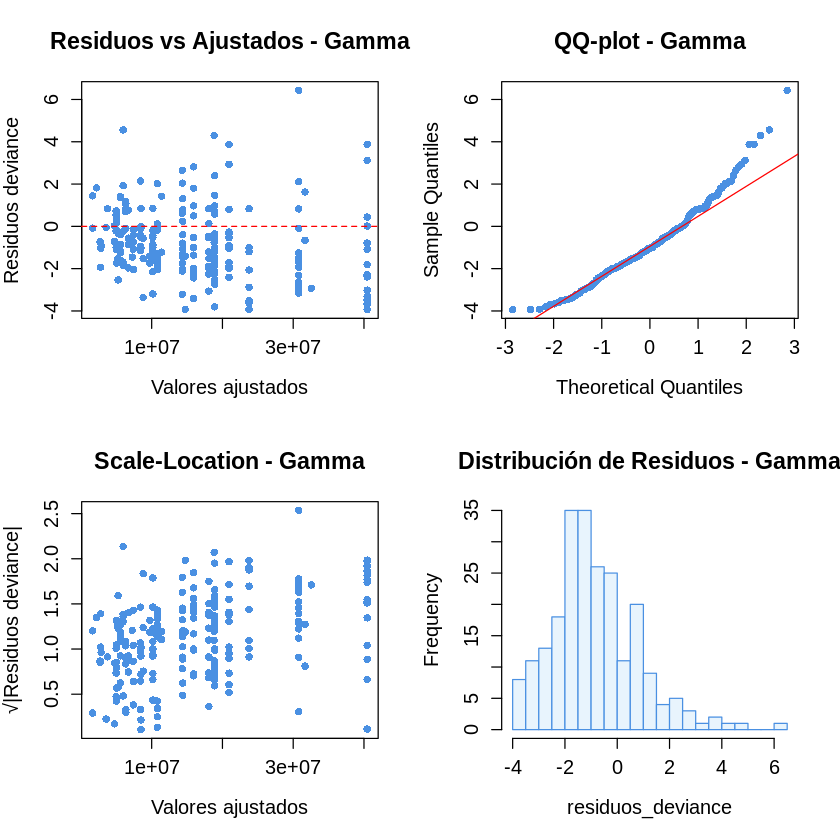

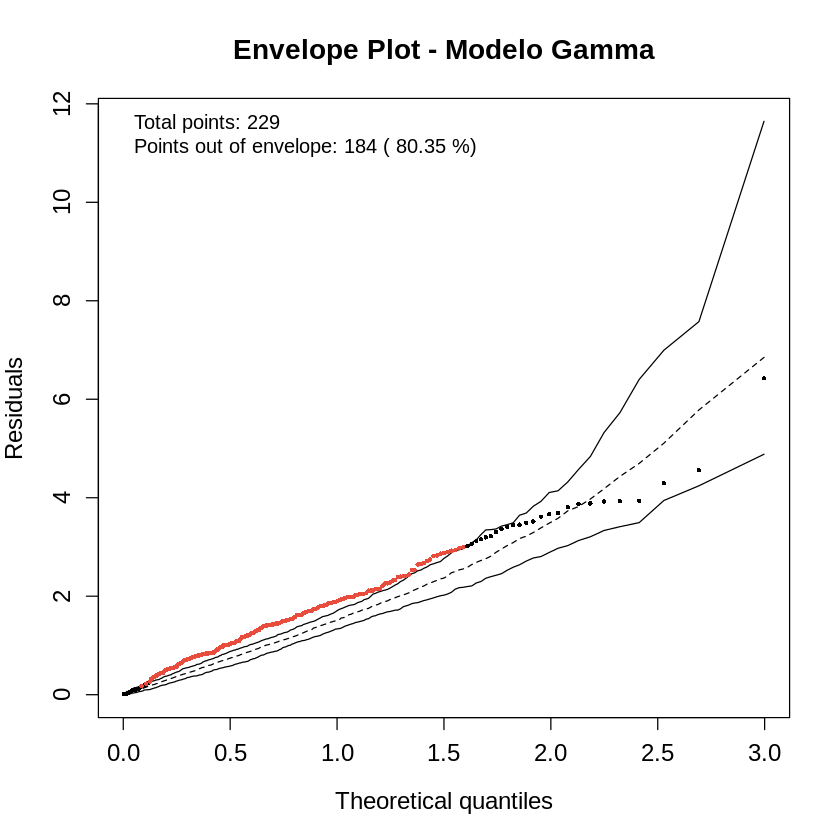

In [42]:
# Gráficos diagnósticos para el modelo Gamma
residuos_deviance <- residuals(modelo_severidad_gamma, type = "deviance")
valores_ajustados <- fitted(modelo_severidad_gamma)

# Guardar diagnósticos en images/
png("../images/diagnosticos_severidad_gamma.png", width = 1000, height = 800, res = 120)
par(mfrow = c(2, 2), cex.axis = 1.4, cex.lab = 1.4, cex.main = 1.6)

plot(valores_ajustados, residuos_deviance, 
     xlab = "Valores ajustados", 
     ylab = "Residuos deviance", 
     main = "Residuos vs Ajustados - Gamma", 
     pch = 16, col = "#4A90E2", cex = 1.2)
abline(h = 0, col = "red", lty = 2, lwd = 2)

qqnorm(residuos_deviance, 
       main = "QQ-plot - Gamma", 
       pch = 16, col = "#4A90E2", cex = 1.2)
qqline(residuos_deviance, col = "red", lwd = 2)

plot(valores_ajustados, sqrt(abs(residuos_deviance)), 
     xlab = "Valores ajustados",
     ylab = "√|Residuos deviance|", 
     main = "Scale-Location - Gamma", 
     pch = 16, col = "#4A90E2", cex = 1.2)

hist(residuos_deviance, breaks = 30, 
     main = "Distribución de Residuos - Gamma",
     xlab = "Residuos deviance",
     col = "#E8F4FD", border = "#4A90E2")

dev.off()

# Mostrar también en notebook
par(mfrow = c(2, 2), cex.axis = 1.2, cex.lab = 1.2, cex.main = 1.4)

plot(valores_ajustados, residuos_deviance, 
     xlab = "Valores ajustados", 
     ylab = "Residuos deviance", 
     main = "Residuos vs Ajustados - Gamma", 
     pch = 16, col = "#4A90E2")
abline(h = 0, col = "red", lty = 2)

qqnorm(residuos_deviance, 
       main = "QQ-plot - Gamma", 
       pch = 16, col = "#4A90E2")
qqline(residuos_deviance, col = "red")

plot(valores_ajustados, sqrt(abs(residuos_deviance)), 
     xlab = "Valores ajustados",
     ylab = "√|Residuos deviance|", 
     main = "Scale-Location - Gamma", 
     pch = 16, col = "#4A90E2")

hist(residuos_deviance, breaks = 30, 
     main = "Distribución de Residuos - Gamma",
     col = "#E8F4FD", border = "#4A90E2")

par(mfrow = c(1, 1))

# Envelope plot para modelo Gamma
set.seed(123)

# Guardar envelope plot en images/
png("../images/envelope_severidad_gamma.png", width = 700, height = 700, res = 120)
par(cex.axis = 1.4, cex.lab = 1.4, cex.main = 1.6)
envelope_gamma <- hnp(modelo_severidad_gamma, 
                     sim = 99, conf = 0.95, halfnormal = TRUE, 
                     scale = TRUE, plot.sim = TRUE, how.many.out = TRUE, 
                     print.on = FALSE, paint.out = TRUE, 
                     main = "Envelope Plot - Modelo Gamma",
                     col.paint.out = "#E74C3C", pch = 16, cex = 1.2)
dev.off()

# Mostrar también en notebook
par(cex.axis = 1.2, cex.lab = 1.2, cex.main = 1.4)
envelope_gamma <- hnp(modelo_severidad_gamma, 
                     sim = 99, conf = 0.95, halfnormal = TRUE, 
                     scale = TRUE, plot.sim = TRUE, how.many.out = TRUE, 
                     print.on = TRUE, paint.out = TRUE, 
                     main = "Envelope Plot - Modelo Gamma",
                     col.paint.out = "#E74C3C", pch = 16)

## **Log-normal**

In [43]:
modelo_sev_completo <- glm(
  log(suma_pagos) ~ Modelo + Color + Carroceria + CLASE_FASECOLDA + 
               TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Edad,
  family = gaussian(link = "identity"),
  weights = n_siniestros,
  data = data
)

modelo_sev_nulo <- glm(
  log(suma_pagos) ~ 1,
  family = gaussian(link = "identity"),
  weights = n_siniestros,
  data = data
)

modelo_severidad_lognormal <- step(
  modelo_sev_completo,
  scope = list(lower = modelo_sev_nulo, upper = modelo_sev_completo),
  direction = "forward",
  trace = TRUE
)

summary(modelo_severidad_lognormal)

Start:  AIC=769.65
log(suma_pagos) ~ Modelo + Color + Carroceria + CLASE_FASECOLDA + 
    TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Edad




Call:
glm(formula = log(suma_pagos) ~ Modelo + Color + Carroceria + 
    CLASE_FASECOLDA + TIPO_VEHICULO + SERVICIO + Sexo_Aseg + 
    Edad, family = gaussian(link = "identity"), data = data, 
    weights = n_siniestros)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.9338  -1.6887  -0.3827   0.8487   7.3230  

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   16.93233    0.18850  89.825  < 2e-16 ***
Modelo1993_1999               -0.82068    0.42433  -1.934 0.054461 .  
Modelo2000_2006               -0.68535    0.21216  -3.230 0.001437 ** 
ColorAMARILLO                 -2.65934    0.82909  -3.208 0.001550 ** 
ColorBLANCO                   -0.80362    0.23824  -3.373 0.000886 ***
ColorPLATA                    -0.60123    0.20080  -2.994 0.003086 ** 
CarroceriaCABINADO            -0.63249    0.46199  -1.369 0.172460    
CarroceriaHATCHBACK            0.16034    0.17742   0.904 0.367169    
Carroceria

## Modelo final

In [44]:
modelo_severidad_lognormal <- glm(
  log(suma_pagos) ~ Modelo + Color + Carroceria + SERVICIO + Edad,
  family = gaussian(link = "identity"),
  weights = n_siniestros,
  data = data
)
summary(modelo_severidad_lognormal)


Call:
glm(formula = log(suma_pagos) ~ Modelo + Color + Carroceria + 
    SERVICIO + Edad, family = gaussian(link = "identity"), data = data, 
    weights = n_siniestros)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-6.4093  -1.6493  -0.3789   0.7947   7.0848  

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 16.86328    0.17198  98.052  < 2e-16 ***
Modelo1993_1999             -0.84907    0.42250  -2.010 0.045727 *  
Modelo2000_2006             -0.67742    0.21073  -3.215 0.001508 ** 
ColorAMARILLO               -2.26855    0.46008  -4.931 1.64e-06 ***
ColorBLANCO                 -0.70948    0.22932  -3.094 0.002240 ** 
ColorPLATA                  -0.58300    0.19745  -2.953 0.003502 ** 
CarroceriaCABINADO          -0.80412    0.25400  -3.166 0.001771 ** 
CarroceriaHATCHBACK          0.17037    0.17664   0.964 0.335886    
CarroceriaOtros             -1.05904    0.27334  -3.874 0.000142 ***
SERVICIOOf

pdf 
  2

Gaussian model (glm object) 
Total points: 229 
Points out of envelope: 4 ( 1.75 %) 


pdf 
  2

Gaussian model (glm object) 


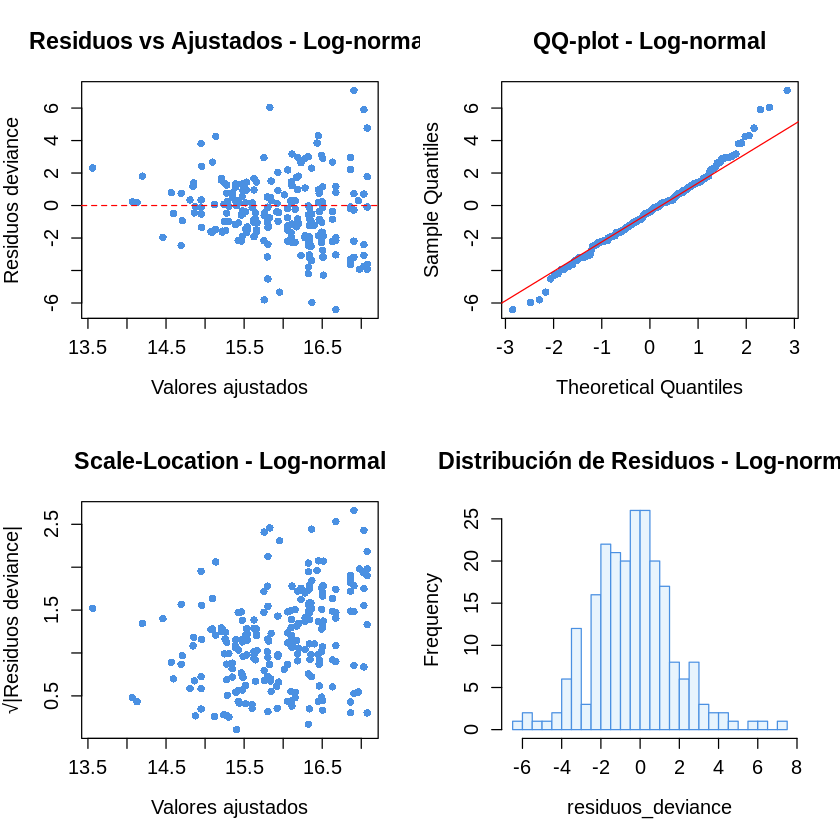

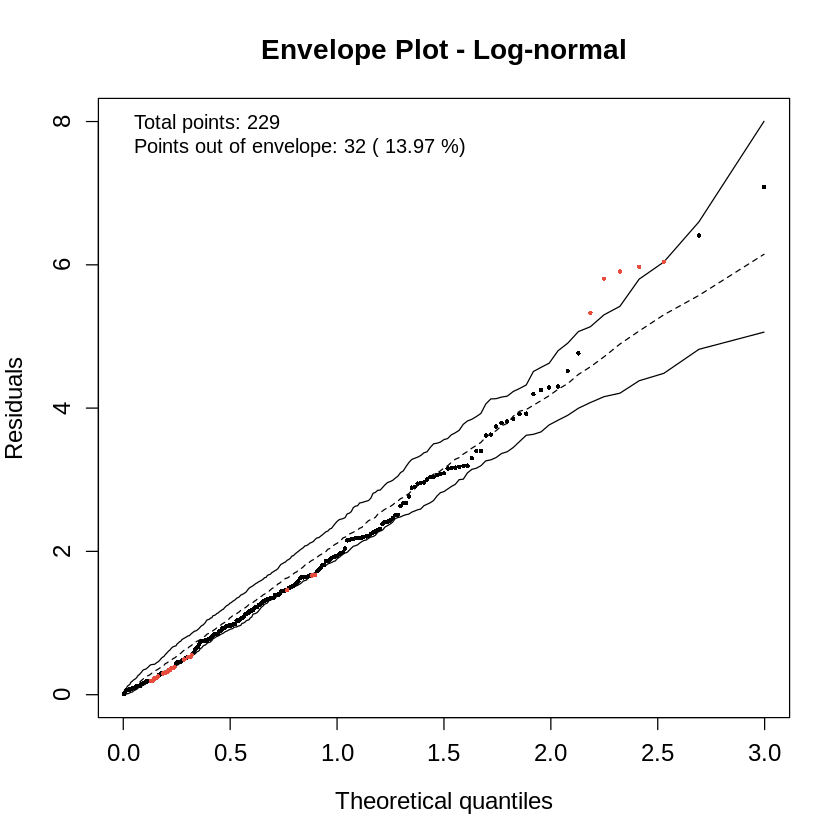

In [45]:
# Gráficos diagnósticos para el modelo Log-normal
residuos_deviance <- residuals(modelo_severidad_lognormal, type = "deviance")
valores_ajustados <- fitted(modelo_severidad_lognormal)

# Guardar diagnósticos en images/
png("../images/diagnosticos_severidad_lognormal.png", width = 1000, height = 800, res = 120)
par(mfrow = c(2, 2), cex.axis = 1.4, cex.lab = 1.4, cex.main = 1.6)

plot(valores_ajustados, residuos_deviance, 
     xlab = "Valores ajustados", 
     ylab = "Residuos deviance", 
     main = "Residuos vs Ajustados - Log-normal", 
     pch = 16, col = "#4A90E2", cex = 1.2)
abline(h = 0, col = "red", lty = 2, lwd = 2)

qqnorm(residuos_deviance, 
       main = "QQ-plot - Log-normal", 
       pch = 16, col = "#4A90E2", cex = 1.2)
qqline(residuos_deviance, col = "red", lwd = 2)

plot(valores_ajustados, sqrt(abs(residuos_deviance)), 
     xlab = "Valores ajustados",
     ylab = "√|Residuos deviance|", 
     main = "Scale-Location - Log-normal", 
     pch = 16, col = "#4A90E2", cex = 1.2)

hist(residuos_deviance, breaks = 30, 
     main = "Distribución de Residuos - Log-normal",
     xlab = "Residuos deviance",
     col = "#E8F4FD", border = "#4A90E2")

dev.off()

# Mostrar también en notebook
par(mfrow = c(2, 2), cex.axis = 1.2, cex.lab = 1.2, cex.main = 1.4)

plot(valores_ajustados, residuos_deviance, 
     xlab = "Valores ajustados", 
     ylab = "Residuos deviance", 
     main = "Residuos vs Ajustados - Log-normal", 
     pch = 16, col = "#4A90E2")
abline(h = 0, col = "red", lty = 2)

qqnorm(residuos_deviance, 
       main = "QQ-plot - Log-normal", 
       pch = 16, col = "#4A90E2")
qqline(residuos_deviance, col = "red")

plot(valores_ajustados, sqrt(abs(residuos_deviance)), 
     xlab = "Valores ajustados",
     ylab = "√|Residuos deviance|", 
     main = "Scale-Location - Log-normal", 
     pch = 16, col = "#4A90E2")

hist(residuos_deviance, breaks = 30, 
     main = "Distribución de Residuos - Log-normal",
     col = "#E8F4FD", border = "#4A90E2")

par(mfrow = c(1, 1))

# Envelope plot para modelo Log-normal
set.seed(123)

# Guardar envelope plot en images/
png("../images/envelope_severidad_lognormal.png", width = 700, height = 700, res = 120)
par(cex.axis = 1.4, cex.lab = 1.4, cex.main = 1.6)
envelope_lognormal <- hnp(modelo_severidad_lognormal, 
                         sim = 99, conf = 0.95, halfnormal = TRUE, 
                         scale = TRUE, plot.sim = TRUE, how.many.out = TRUE, 
                         print.on = FALSE, paint.out = TRUE, 
                         main = "Envelope Plot - Log-normal",
                         col.paint.out = "#E74C3C", pch = 16, cex = 1.2)
dev.off()

# Mostrar también en notebook
par(cex.axis = 1.2, cex.lab = 1.2, cex.main = 1.4)
envelope_lognormal <- hnp(modelo_severidad_lognormal, 
                         sim = 99, conf = 0.95, halfnormal = TRUE, 
                         scale = TRUE, plot.sim = TRUE, how.many.out = TRUE, 
                         print.on = TRUE, paint.out = TRUE, 
                         main = "Envelope Plot - Log-normal",
                         col.paint.out = "#E74C3C", pch = 16)

## Exportando

In [46]:
saveRDS(modelo_severidad_gamma, file = "../models/modelo_severidad_gamma.rds")

modelo_info <- list(
  modelo = modelo_severidad_gamma,
  aic = AIC(modelo_severidad_gamma),
  formula = formula(modelo_severidad_gamma),
  family = "Gamma",
  fecha_entrenamiento = Sys.Date()
)

saveRDS(modelo_info, file = "../models/modelo_severidad_gamma_completo.rds")

In [47]:
saveRDS(modelo_severidad_lognormal, file = "../models/modelo_severidad_lognormal.rds")

modelo_info <- list(
  modelo = modelo_severidad_lognormal,
  aic = AIC(modelo_severidad_lognormal),
  formula = formula(modelo_severidad_lognormal),
  family = "lognormal",
  fecha_entrenamiento = Sys.Date()
)

saveRDS(modelo_info, file = "../models/modelo_severidad_lognormal_completo.rds")